In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from algorithm import *
from explainer import *
from genetic import *
import dalex as dx
from XGB import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv('../../../Dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [4]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.0,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.0,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URLLength                   235795 non-null  int64  
 1   DomainLength                235795 non-null  int64  
 2   IsDomainIP                  235795 non-null  int64  
 3   URLSimilarityIndex          235795 non-null  float64
 4   CharContinuationRate        235795 non-null  float64
 5   TLDLegitimateProb           235795 non-null  float64
 6   URLCharProb                 235795 non-null  float64
 7   TLDLength                   235795 non-null  int64  
 8   NoOfSubDomain               235795 non-null  int64  
 9   HasObfuscation              235795 non-null  int64  
 10  NoOfObfuscatedChar          235795 non-null  int64  
 11  ObfuscationRatio            235795 non-null  float64
 12  NoOfLettersInURL            235795 non-null  int64  
 13  LetterRatioInU

In [6]:
protected_feature = 'IsHTTPS'

In [7]:
x_train, x_test, y_train, y_test, feature_names = Data_Handler(
        df=data,
        target_column='label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...


Scaling numerical features: ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']


In [8]:
print(len(x_train.columns))
x_train.head()

19


,URLLength,DomainLength,IsDomainIP,TLDLegitimateProb,HasObfuscation,IsHTTPS,LineOfCode,LargestLineLength,Robots,NoOfURLRedirect,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfEmptyRef
98258,-0.134650,0.059642,0,-0.922760,0,1,-0.185396,-0.077576,0,0,-0.053741,0.067997,0,0,0,0,0,-0.015936,0.032389
131577,-0.231504,-0.379189,0,-0.922760,0,1,0.422297,-0.074531,0,0,-0.053741,-0.095874,0,0,0,0,0,-0.060824,0.350060
201592,-0.183077,-0.159773,0,1.041476,0,1,0.180121,-0.075475,1,0,-0.053741,-0.259745,0,0,0,0,0,-0.049602,0.032389
159643,-0.134650,0.059642,0,-1.028299,0,1,1.472474,-0.056584,0,0,-0.053741,3.345417,0,1,1,1,0,-0.049602,0.138279
170726,-0.328358,-0.818020,0,-0.964647,0,1,-0.184108,-0.016243,1,0,-0.053741,0.067997,0,0,1,0,1,0.230949,-0.020556


In [9]:
feature_names

['URLLength',
 'DomainLength',
 'IsDomainIP',
 'TLDLegitimateProb',
 'HasObfuscation',
 'IsHTTPS',
 'LineOfCode',
 'LargestLineLength',
 'Robots',
 'NoOfURLRedirect',
 'NoOfPopup',
 'NoOfiFrame',
 'HasExternalFormSubmit',
 'HasPasswordField',
 'Bank',
 'Pay',
 'Crypto',
 'NoOfCSS',
 'NoOfEmptyRef']

In [10]:
# Assuming X_train, X_test, y_train, y_test are already separated
# And df is the original DataFrame with its original column names (e.g., 'thalach', 'trestbps', 'chol')

# Define VARIABLES_TO_CHANGE using the original column names
VARIABLES_TO_CHANGE = ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']

# Define the full list of columns you want to select for your features
selected_columns = [protected_feature] + VARIABLES_TO_CHANGE

# Apply the column selection to X_train and X_test
x_train = x_train.loc[:, selected_columns]
x_test = x_test.loc[:, selected_columns]

# y_train and y_test remain unchanged as they already contain the target variable

Accuracy: 0.9959993779951654
Precision: 0.9960006081915692
Recall: 0.9959993779951654
F-1: 0.9959987246627731


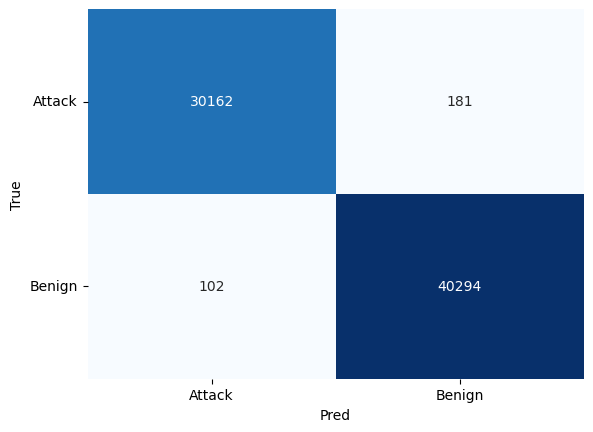

In [11]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [12]:
explainer = Explainer(model, x_test[:300])

In [13]:
e = dx.Explainer(model, x_test[:300], y_test[:300], verbose=False)
e.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.997475,0.995528,0.996501,0.995999,0.999865


In [14]:
pd.DataFrame({'variable': x_train.columns, 'importance_split': model.feature_importances_,
              'importance_shap': explainer.shap_values(explainer.data),
              'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})


 99%|===================| 69986/70739 [00:52<00:00]        

,variable,importance_split,importance_shap,importance_perm
7,IsHTTPS,0.050795,0.088011,0.000760
10,URLLength,0.069271,0.077562,0.132713
6,DomainLength,0.030708,0.004947,0.000621
2,TLDLegitimateProb,0.013104,0.006289,0.000170
3,LineOfCode,0.365466,0.245367,0.000173
1,LargestLineLength,0.014561,0.020242,0.000170
4,NoOfPopup,0.012083,0.000677,0.000233
9,NoOfiFrame,0.012803,0.003470,0.015094
11,NoOfCSS,0.407571,0.041275,0.494013
0,NoOfEmptyRef,0.023639,0.005333,0.000170


In [15]:
I = 36
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I)
e.data.iloc[[I]].assign(y=e.y[[I]], y_hat=e.y_hat[[I]])

,IsHTTPS,URLLength,DomainLength,TLDLegitimateProb,LineOfCode,LargestLineLength,NoOfPopup,NoOfiFrame,NoOfCSS,NoOfEmptyRef,y,y_hat
198462,1,-0.255717,-0.488897,-0.718499,0.052915,-0.069568,0.177598,1.378965,0.085062,-0.020556,1,0.996385


In [16]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X, a._x)
t = np.array([i + (t[0] / (len(t) - 3)) if i > 0 else i - (t[0] / (len(t) - 3)) for i in t])
t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X, a._x), 'target': t})

,variable,shap_values,target
0,IsHTTPS,0.078162,-0.005000
1,URLLength,0.073900,0.085066
2,DomainLength,-0.003570,-0.014736
3,TLDLegitimateProb,0.003207,0.014373
4,LineOfCode,0.225652,0.236818
5,LargestLineLength,0.017456,0.028622
6,NoOfPopup,0.006898,0.018064
7,NoOfiFrame,0.004918,0.016084
8,NoOfCSS,0.024636,0.035802
9,NoOfEmptyRef,0.006255,0.017421


In [17]:
a.fool_aim(target=t, max_iter=100, random_state=0)

Iter: 100 || Loss: 0.493743278204393: 100%|██████████| 100/100 [17:01<00:00, 10.22s/it]


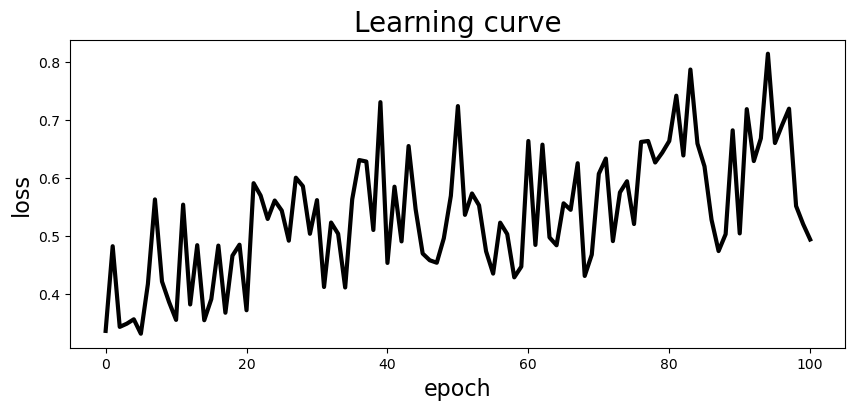

In [18]:
a.plot_losses()

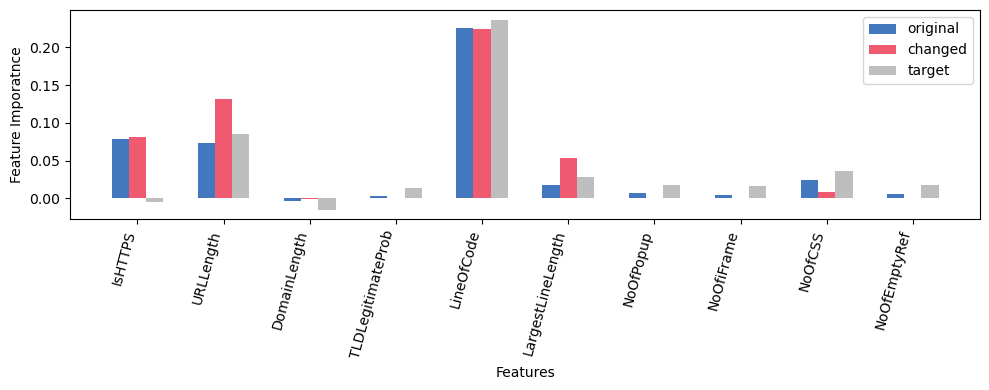

In [19]:
a.plot_explanation()

/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When

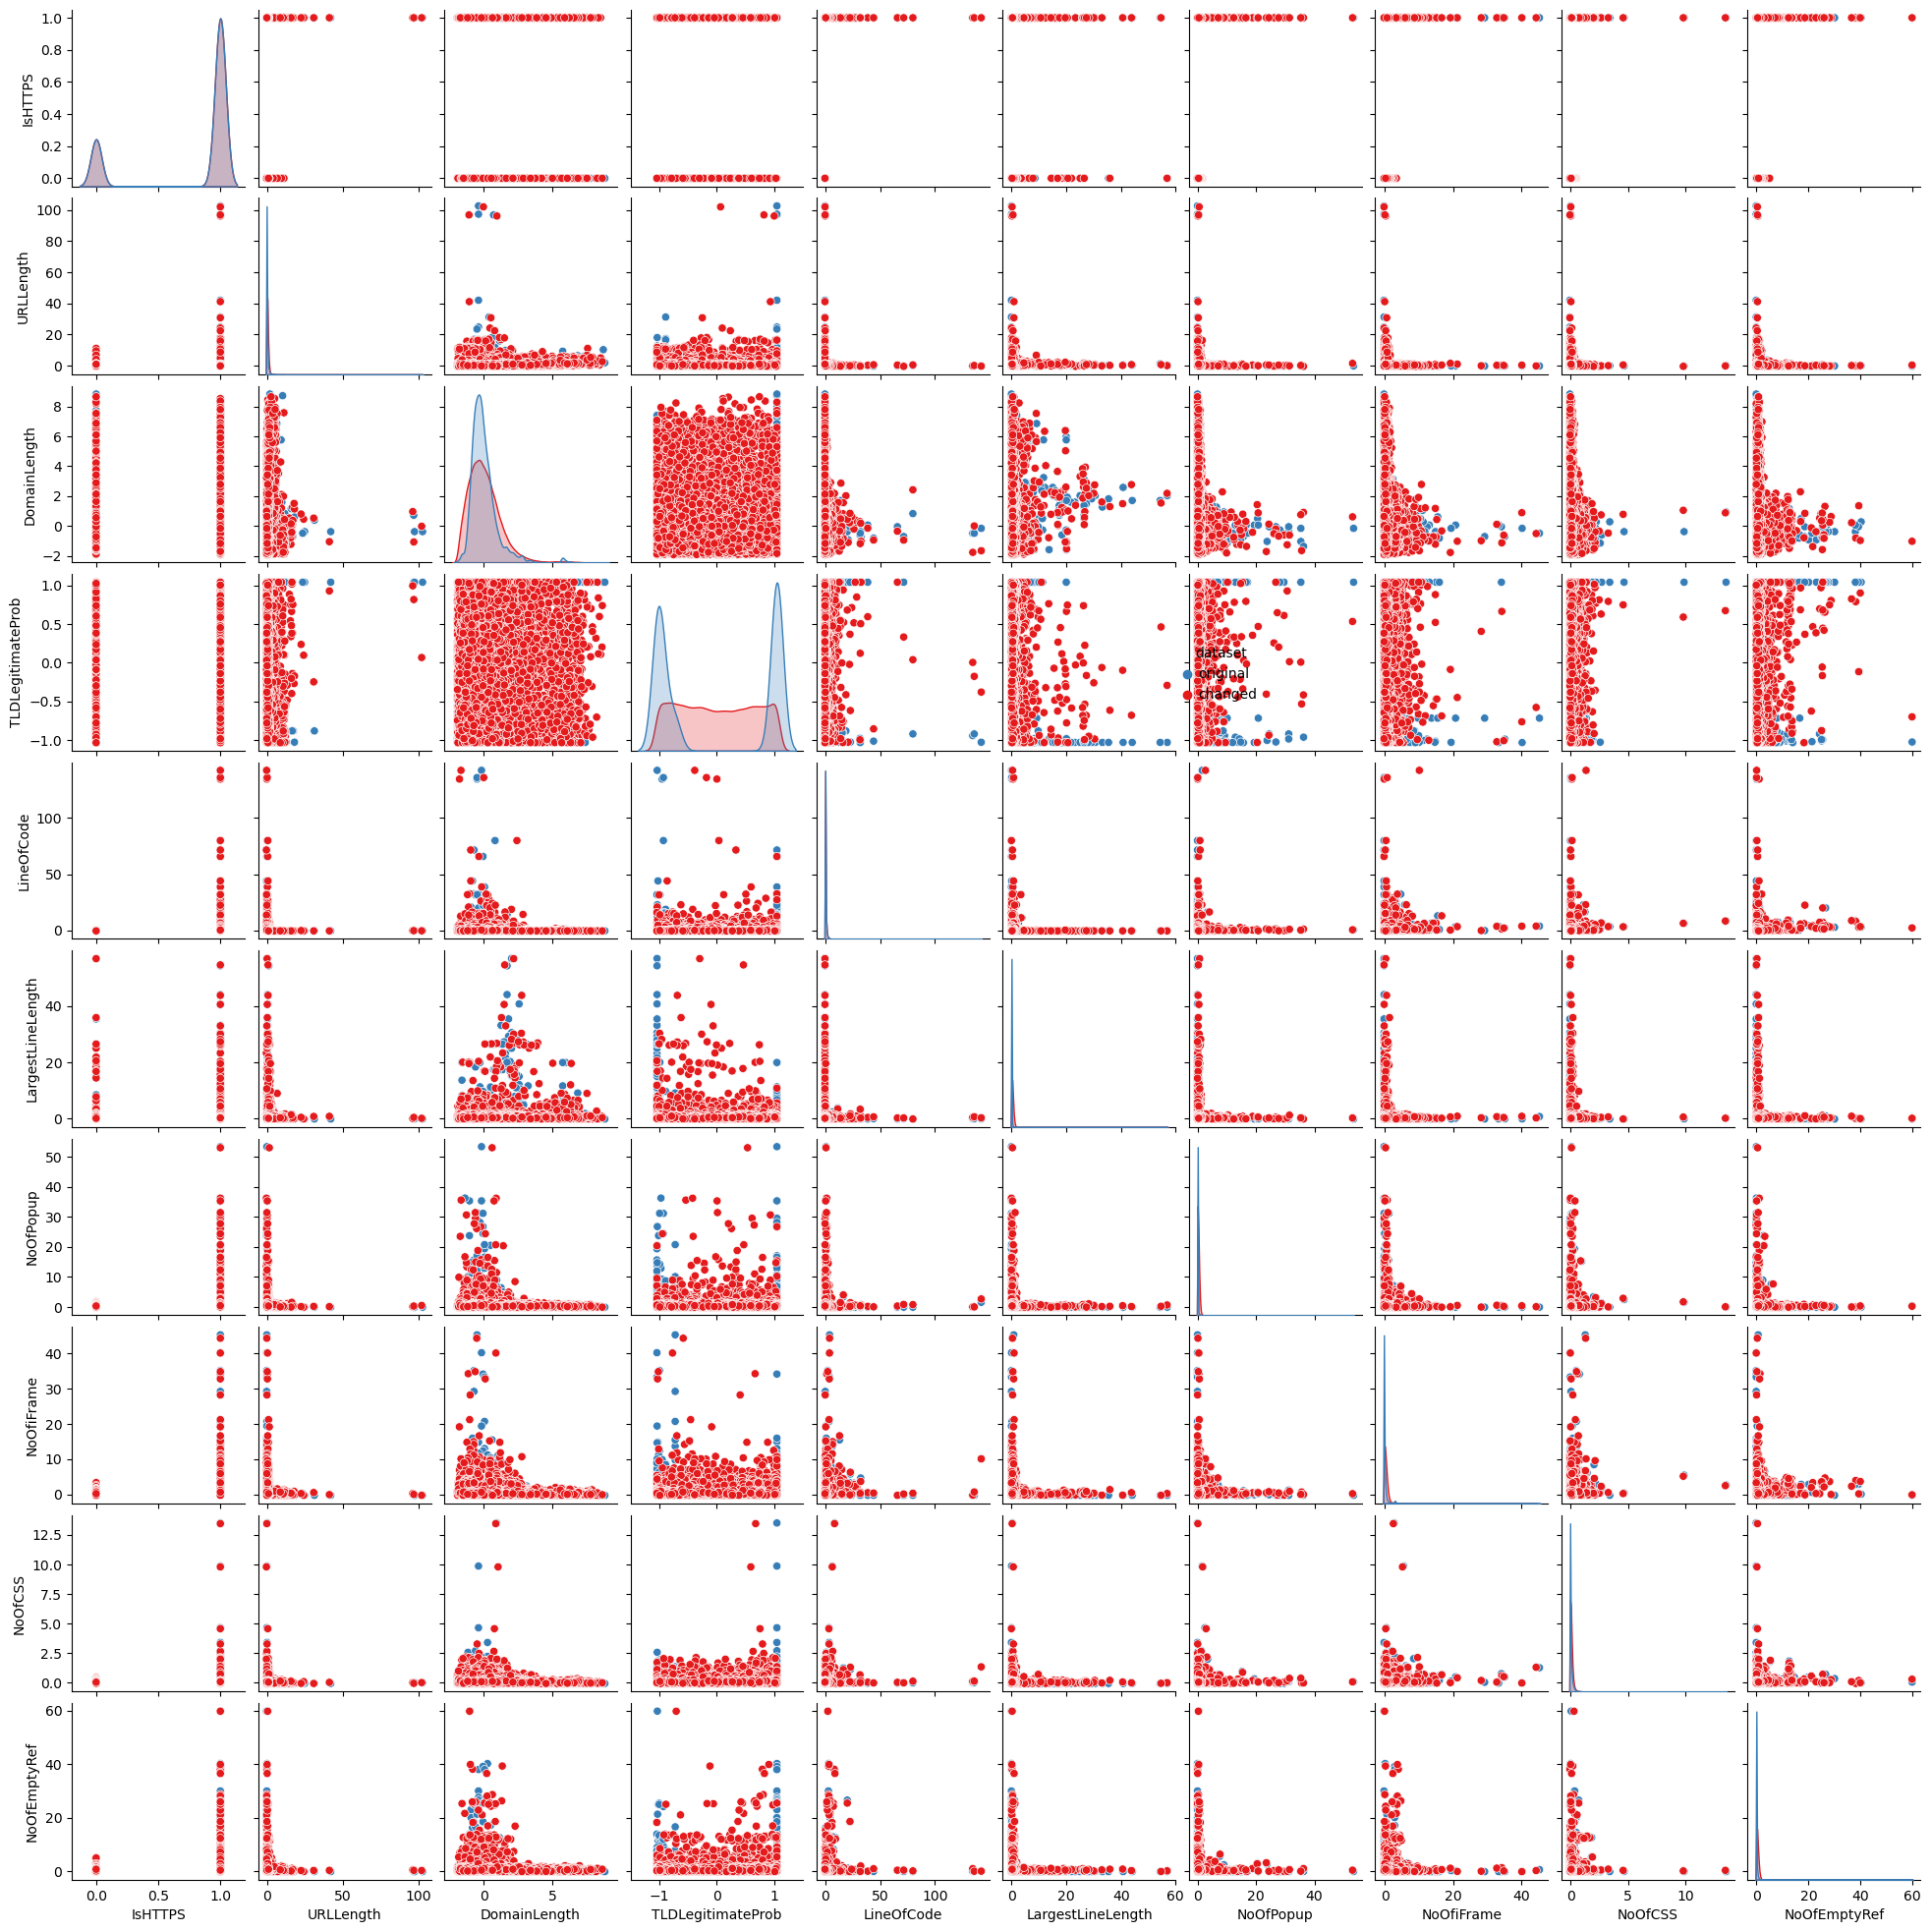

In [20]:
a.plot_data()

In [ ]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X)
# print(t)
t = np.array([i*0+np.mean(t)*2.75 for i in t])
# t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X), 'target': t})

In [ ]:
a.fool_aim(target=np.array(t), max_iter=200, random_state=0)

In [ ]:
a.plot_explanation()

In [ ]:
a.plot_data()

In [ ]:
a.display_feature_rank_changes()